Required installation

In [1]:
%pip install -q transformers datasets scikit-learn accelerate

Note: you may need to restart the kernel to use updated packages.


Required imports

In [2]:
from datasets import load_dataset
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    DataCollatorWithPadding,
    TrainingArguments,
    Trainer,
)
from sklearn.metrics import accuracy_score, f1_score, classification_report
import numpy as np
import torch
import os

c:\Users\shiva\anaconda3\envs\shiva\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\shiva\anaconda3\envs\shiva\Lib\site-packages\sklearn\utils\_param_validation.py:14: UserWarning: A NumPy version >=1.23.5 and <2.3.0 is required for this version of SciPy (detected version 2.3.1)
  from scipy.sparse import csr_matrix, issparse


Loading dataset from huggingface

In [3]:
dataset = load_dataset("dair-ai/emotion")

print(dataset)

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})


Label mapping

In [4]:
label_list = dataset["train"].features["label"].names
num_labels = len(label_list)
id2label = {i: l for i, l in enumerate(label_list)}
label2id = {l: i for i, l in enumerate(label_list)}
print("Labels:", id2label)

Labels: {0: 'sadness', 1: 'joy', 2: 'love', 3: 'anger', 4: 'fear', 5: 'surprise'}


In [5]:
checkpoint = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

In [6]:
def preprocess_function(examples):
    return tokenizer(
        examples["text"],
        truncation=True,
        padding=False,  # we'll pad dynamically with DataCollator
        max_length=128,
    )

Baseline fine-tuning (FP32/FP16):

In [7]:
encoded_dataset = dataset.map(preprocess_function, batched=True)

# Remove unused columns so Trainer only sees what it needs
encoded_dataset = encoded_dataset.remove_columns(["text"])
encoded_dataset.set_format(type="torch")

# ============================================================
#  Load model (baseline FP32 / optional FP16 during training)
# ============================================================
model = AutoModelForSequenceClassification.from_pretrained(
    checkpoint,
    num_labels=num_labels,
    id2label=id2label,
    label2id=label2id,
)

# ============================================================
#  Data collator (dynamic padding)
# ============================================================
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

# ============================================================
#  Metrics: accuracy + macro F1
# ============================================================
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    if isinstance(logits, (tuple, list)):
        logits = logits[0]
    preds = np.argmax(logits, axis=-1)
    acc = accuracy_score(labels, preds)
    macro_f1 = f1_score(labels, preds, average="macro")
    return {"accuracy": acc, "macro_f1": macro_f1}

# ============================================================
#  Training arguments
# ============================================================
output_dir = "bert_emotion_baseline"

training_args = TrainingArguments(
    output_dir=output_dir,
    num_train_epochs=3,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=64,
    learning_rate=2e-5,
    weight_decay=0.01,
    logging_steps=50,
    save_steps=1000,
    eval_steps=1000,
    eval_strategy="steps",  
    save_strategy="steps",  
    load_best_model_at_end=True,
    metric_for_best_model="macro_f1",
    fp16=torch.cuda.is_available(),
    report_to="none", 
)

# ============================================================
#  Trainer
# ============================================================
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=encoded_dataset["train"],
    eval_dataset=encoded_dataset["validation"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)



Map: 100%|██████████| 2000/2000 [00:00<00:00, 10145.80 examples/s]
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\shiva\AppData\Local\Temp\ipykernel_8212\3735649500.py:60: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


#  Train baseline model

In [8]:
trainer.train()

# ============================================================
#  Evaluate on validation and test
# ============================================================
print("Validation metrics:")
val_metrics = trainer.evaluate(encoded_dataset["validation"])
print(val_metrics)

print("\nTest metrics:")
test_metrics = trainer.evaluate(encoded_dataset["test"])
print(test_metrics)

# ============================================================
#  Save model & tokenizer (for GitHub upload)
#    -> After this, you can zip the folder and commit to a public GitHub repo
# ============================================================
save_path = "saved_bert_emotion_baseline"
os.makedirs(save_path, exist_ok=True)

trainer.save_model(save_path)            # saves model + config
tokenizer.save_pretrained(save_path)     # saves tokenizer files

print(f"Model saved to: {save_path}")

Step,Training Loss,Validation Loss,Accuracy,Macro F1
1000,0.123500,0.158021,0.936000,0.907925


Validation metrics:


{'eval_loss': 0.15802130103111267, 'eval_accuracy': 0.936, 'eval_macro_f1': 0.9079247244953336, 'eval_runtime': 4.4958, 'eval_samples_per_second': 444.863, 'eval_steps_per_second': 7.118, 'epoch': 3.0}

Test metrics:
{'eval_loss': 0.17462970316410065, 'eval_accuracy': 0.928, 'eval_macro_f1': 0.888150485686184, 'eval_runtime': 4.3657, 'eval_samples_per_second': 458.117, 'eval_steps_per_second': 7.33, 'epoch': 3.0}
Model saved to: saved_bert_emotion_baseline


In [9]:
baseline_save_path = save_path
baseline_model_path = baseline_save_path


In [ ]:
# !git clone 

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Cloning into 'Bert_finetuning_on_dair-ai-emotion'...
remote: Enumerating objects: 14, done.
remote: Counting objects: 100% (14/14), done.
remote: Compressing objects: 100% (13/13), done.
remote: Total 14 (delta 1), reused 14 (delta 1), pack-reused 0 (from 0)
Unpacking objects: 100% (14/14), 315.65 KiB | 2.50 MiB/s, done.


In [10]:
# baseline_model_path = "Bert_finetuning_on_dair-ai-emotion/saved_bert_emotion_baseline"

In [11]:
loaded_model = AutoModelForSequenceClassification.from_pretrained(
    baseline_model_path,
    num_labels=num_labels,
    id2label=id2label,
    label2id=label2id,
)
loaded_tokenizer = AutoTokenizer.from_pretrained(baseline_model_path)

# ---------- Single-sentence inference demo ----------
def predict_emotion(text):
    inputs = loaded_tokenizer(
        text,
        return_tensors="pt",
        truncation=True,
        max_length=128,
    )
    with torch.no_grad():
        outputs = loaded_model(**inputs)
        logits = outputs.logits
        pred_id = torch.argmax(logits, dim=-1).item()
    return id2label[pred_id]

example_text = "I am really happy with my results!"
print("Text:", example_text)
print("Predicted emotion:", predict_emotion(example_text))

# ---------- Full test evaluation using loaded model ----------
loaded_trainer = Trainer(
    model=loaded_model,
    args=training_args,
    eval_dataset=encoded_dataset["test"],
    tokenizer=loaded_tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

print("\nTest metrics (reloaded model):")
reloaded_test_metrics = loaded_trainer.evaluate()
print(reloaded_test_metrics)

# Optional: detailed per-class report (for your later assignment parts)
preds_output = loaded_trainer.predict(encoded_dataset["test"])
logits = preds_output.predictions
if isinstance(logits, (tuple, list)):
    logits = logits[0]
y_pred = np.argmax(logits, axis=-1)
y_true = preds_output.label_ids

print("\nClassification report (per-class metrics):")
print(classification_report(y_true, y_pred, target_names=label_list))

Text: I am really happy with my results!
Predicted emotion: joy


C:\Users\shiva\AppData\Local\Temp\ipykernel_8212\1835544063.py:28: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  loaded_trainer = Trainer(



Test metrics (reloaded model):


{'eval_loss': 0.17462970316410065, 'eval_model_preparation_time': 0.0071, 'eval_accuracy': 0.928, 'eval_macro_f1': 0.888150485686184, 'eval_runtime': 4.6525, 'eval_samples_per_second': 429.877, 'eval_steps_per_second': 6.878}

Classification report (per-class metrics):
              precision    recall  f1-score   support

     sadness       0.95      0.98      0.96       581
         joy       0.95      0.95      0.95       695
        love       0.84      0.81      0.82       159
       anger       0.96      0.88      0.92       275
        fear       0.88      0.94      0.91       224
    surprise       0.78      0.76      0.77        66

    accuracy                           0.93      2000
   macro avg       0.89      0.88      0.89      2000
weighted avg       0.93      0.93      0.93      2000



Post-Training Quantization (PTQ)

In [12]:
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification

model_path = baseline_save_path

tokenizer = AutoTokenizer.from_pretrained(model_path)

baseline_model = AutoModelForSequenceClassification.from_pretrained(
    model_path,
    use_safetensors=True
).to("cpu")  # quantization is CPU-only


In [13]:
%pip install seaborn

Note: you may need to restart the kernel to use updated packages.


Map: 100%|██████████| 2000/2000 [00:00<00:00, 10908.85 examples/s]


Quantized Model Accuracy: 0.922
Quantized Model Macro F1: 0.8714083890030077

Per-class metrics:

              precision    recall  f1-score   support

     sadness       0.94      0.97      0.96       581
         joy       0.90      0.98      0.94       695
        love       0.96      0.67      0.79       159
       anger       0.96      0.88      0.92       275
        fear       0.88      0.92      0.90       224
    surprise       0.89      0.61      0.72        66

    accuracy                           0.92      2000
   macro avg       0.92      0.84      0.87      2000
weighted avg       0.92      0.92      0.92      2000

Baseline Model Size: 418.59 MB
PTQ Model Size:      173.09 MB
Baseline Latency: 73.65 ms
Quantized Latency: 35.50 ms


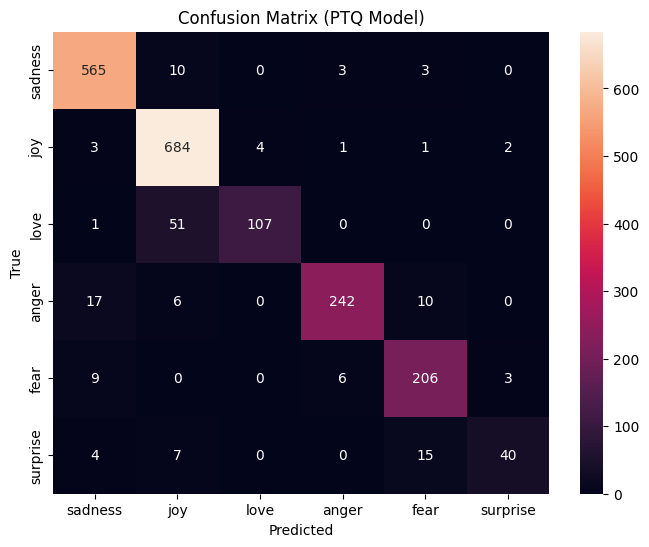

In [14]:
import torch.quantization

quantized_model = torch.quantization.quantize_dynamic(
    baseline_model,
    {torch.nn.Linear},     # Quantize linear layers
    dtype=torch.qint8      # 8-bit weights
)
from datasets import load_dataset
from sklearn.metrics import accuracy_score, f1_score, classification_report
import numpy as np

dataset = load_dataset("dair-ai/emotion")
label_list = dataset["train"].features["label"].names

def encode_batch(batch):
    return tokenizer(batch["text"], truncation=True, padding=True, max_length=128)

encoded = dataset.map(encode_batch, batched=True)
encoded.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])

test_loader = torch.utils.data.DataLoader(encoded["test"], batch_size=32)

def evaluate(model):
    model.eval()
    all_preds, all_labels = [], []

    with torch.no_grad():
        for batch in test_loader:
            outputs = model(
                input_ids=batch["input_ids"],
                attention_mask=batch["attention_mask"]
            )
            preds = torch.argmax(outputs.logits, dim=1)
            all_preds.extend(preds.numpy())
            all_labels.extend(batch["label"].numpy())

    acc = accuracy_score(all_labels, all_preds)
    macro_f1 = f1_score(all_labels, all_preds, average="macro")

    return acc, macro_f1, all_labels, all_preds

acc, macro_f1, y_true, y_pred = evaluate(quantized_model)

print("Quantized Model Accuracy:", acc)
print("Quantized Model Macro F1:", macro_f1)
print("\nPer-class metrics:\n")
print(classification_report(y_true, y_pred, target_names=label_list))
import os

def get_size(path):
    size = sum(os.path.getsize(os.path.join(path, f)) 
               for f in os.listdir(path))
    return size / (1024 * 1024)  # MB

baseline_size = get_size(model_path)
torch.save(quantized_model.state_dict(), "ptq_model.pth")
ptq_size = os.path.getsize("ptq_model.pth") / (1024 * 1024)

print(f"Baseline Model Size: {baseline_size:.2f} MB")
print(f"PTQ Model Size:      {ptq_size:.2f} MB")
import time

def measure_latency(model, text="I feel great today!"):
    inputs = tokenizer(text, return_tensors="pt")

    # Warmup
    for _ in range(5):
        _ = model(**inputs)

    start = time.time()
    for _ in range(50):
        _ = model(**inputs)
    end = time.time()

    return (end - start) / 50

baseline_latency = measure_latency(baseline_model)
quantized_latency = measure_latency(quantized_model)

print(f"Baseline Latency: {baseline_latency*1000:.2f} ms")
print(f"Quantized Latency: {quantized_latency*1000:.2f} ms")
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=label_list, yticklabels=label_list)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix (PTQ Model)")
plt.show()


Quantization-Aware Training (QAT)

In [15]:
# ----------------------- PART 1: QAT TRAINING -----------------------
import torch
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch.nn as nn
import os

model_path = baseline_save_path   # your GitHub baseline path

# Load tokenizer + dataset
tokenizer = AutoTokenizer.from_pretrained(model_path)
dataset = load_dataset("dair-ai/emotion")

label_list = dataset["train"].features["label"].names
num_labels = len(label_list)

def preprocess(batch):
    return tokenizer(batch["text"], truncation=True, padding="max_length", max_length=128)

encoded = dataset.map(preprocess, batched=True)
encoded.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])

# Data loaders
train_loader = torch.utils.data.DataLoader(encoded["train"], batch_size=16, shuffle=True)

# Load baseline FP32 model
model = AutoModelForSequenceClassification.from_pretrained(model_path, num_labels=num_labels)

# ---------------- FREEZE LAYERS ----------------
FREEZE_UP_TO = 8
for name, param in model.named_parameters():
    if name.startswith("bert.encoder.layer."):
        layer_id = name.split(".")[3]
        if layer_id.isdigit() and int(layer_id) < FREEZE_UP_TO:
            param.requires_grad = False

# ---------------- PREPARE FOR QAT ----------------
model.train()
qat_model = torch.quantization.prepare_qat(model, inplace=False)

optimizer = torch.optim.Adam(
    filter(lambda p: p.requires_grad, qat_model.parameters()),
    lr=1e-5
)
loss_fn = nn.CrossEntropyLoss()

# ---------------- TRAIN ----------------
epochs = 2
for epoch in range(epochs):
    total_loss = 0
    qat_model.train()

    for batch in train_loader:
        optimizer.zero_grad()
        outputs = qat_model(
            input_ids=batch["input_ids"],
            attention_mask=batch["attention_mask"]
        )
        loss = loss_fn(outputs.logits, batch["label"])
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss:.4f}")

# ---------------- CONVERT TO INT8 + SAVE ----------------
qat_model.eval()
quantized_int8_model = torch.quantization.convert(qat_model.to("cpu"), inplace=False)

# Save QAT model weights
save_dir = "qat_model_int8"
os.makedirs(save_dir, exist_ok=True)

torch.save(quantized_int8_model.state_dict(), f"{save_dir}/model_int8.pth")
tokenizer.save_pretrained(save_dir)

print("QAT training complete. Model saved at:", save_dir)
# ----------------------- END OF PART 1 -----------------------


Map: 100%|██████████| 2000/2000 [00:00<00:00, 8774.68 examples/s]
c:\Users\shiva\anaconda3\envs\shiva\Lib\site-packages\torch\ao\quantization\quantize.py:392: UserWarning: None of the submodule got qconfig applied. Make sure you passed correct configuration through `qconfig_dict` or by assigning the `.qconfig` attribute directly on submodules
  warnings.warn(


Epoch 1/2, Loss: 103.2378
Epoch 2/2, Loss: 92.2957
QAT training complete. Model saved at: qat_model_int8


In [ ]:
# ----------------------- PART 2: QAT EVALUATION -----------------------
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from datasets import load_dataset
from sklearn.metrics import accuracy_score, f1_score, classification_report
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import time

# Load tokenizer + dataset again
eval_model_path = "qat_model_int8"      # folder created in part 1
tokenizer = AutoTokenizer.from_pretrained(eval_model_path)
dataset = load_dataset("dair-ai/emotion")

label_list = dataset["train"].features["label"].names

def preprocess(batch):
    return tokenizer(batch["text"], truncation=True, padding="max_length", max_length=128)

encoded = dataset.map(preprocess, batched=True)
encoded.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])

test_loader = torch.utils.data.DataLoader(encoded["test"], batch_size=32)

# Rebuild model in FP32 shape but load INT8 weights
model = AutoModelForSequenceClassification.from_pretrained(
    baseline_save_path,  # restore model architecture
    num_labels=len(label_list)
)

state = torch.load(f"{eval_model_path}/model_int8.pth", map_location="cpu")
model.load_state_dict(state)

model.eval()

# ---------------- EVALUATION ----------------
def evaluate(model):
    preds, trues = [], []
    with torch.no_grad():
        for batch in test_loader:
            out = model(
                input_ids=batch["input_ids"],
                attention_mask=batch["attention_mask"]
            )
            p = torch.argmax(out.logits, dim=1)
            preds.extend(p.numpy())
            trues.extend(batch["label"].numpy())

    acc = accuracy_score(trues, preds)
    macro_f1 = f1_score(trues, preds, average="macro")
    return acc, macro_f1, trues, preds

acc, macro_f1, y_true, y_pred = evaluate(model)

print("QAT Accuracy:", acc)
print("QAT Macro F1:", macro_f1)
print("\nClassification Report:\n")
print(classification_report(y_true, y_pred, target_names=label_list))

# ---------------- LATENCY ----------------
def measure_latency(model):
    text = "I feel amazing today!"
    inputs = tokenizer(text, return_tensors="pt")

    # warmup
    for _ in range(5):
        _ = model(**inputs)

    start = time.time()
    for _ in range(50):
        _ = model(**inputs)
    end = time.time()
    return (end - start) / 50

lat = measure_latency(model)
print(f"QAT Latency: {lat * 1000:.2f} ms")

# ---------------- CONFUSION MATRIX ----------------
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=label_list, yticklabels=label_list)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("QAT Confusion Matrix")
plt.show()

# ----------------------- END OF PART 2 -----------------------


SyntaxError: (unicode error) 'unicodeescape' codec can't decode bytes in position 2-3: truncated \UXXXXXXXX escape (2373892569.py, line 13)

In [51]:
%pip install -q transformers datasets accelerate bitsandbytes peft


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


Quantized Low Rank Adaptation (QLoRA)

In [52]:
from transformers import AutoModelForSequenceClassification, BitsAndBytesConfig

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_use_double_quant=True,
    bnb_4bit_compute_dtype="float16",
)

base_model = AutoModelForSequenceClassification.from_pretrained(
    "bert-base-uncased",
    num_labels=num_labels,
    quantization_config=bnb_config,
    device_map="auto"
)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [53]:
from peft import LoraConfig, get_peft_model, TaskType

lora_config = LoraConfig(
    r=8,
    lora_alpha=16,
    lora_dropout=0.05,
    target_modules=["query", "key", "value", "dense"],
    task_type=TaskType.SEQ_CLS,
)

model = get_peft_model(base_model, lora_config)


In [ ]:
# from transformers import TrainingArguments, Trainer

# training_args = TrainingArguments(
#     output_dir="qlora_bert_emotion",
#     learning_rate=2e-4,
#     num_train_epochs=3,
#     per_device_train_batch_size=16,
#     per_device_eval_batch_size=32,
#     logging_steps=50,
#     eval_strategy="epoch",
#     save_strategy="epoch",
#     load_best_model_at_end=True,
#     bf16=True
# )

# def compute_metrics(eval_pred):
#     import numpy as np
#     from sklearn.metrics import accuracy_score, f1_score

#     logits, labels = eval_pred
#     preds = logits.argmax(axis=1)
#     return {
#         "accuracy": accuracy_score(labels, preds),
#         "macro_f1": f1_score(labels, preds, average="macro")
#     }

# trainer = Trainer(
#     model=model,
#     tokenizer=tokenizer,
#     train_dataset=encoded["train"],
#     eval_dataset=encoded["validation"],
#     args=training_args,
#     compute_metrics=compute_metrics
# )

# trainer.train()


/tmp/ipykernel_3398019/2172610896.py:27: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/data4/babu/Multilingual_factchecking/venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,Macro F1
1,0.000000,nan,0.275000,0.071895
2,0.000000,nan,0.275000,0.071895
3,0.000000,nan,0.275000,0.071895


/data4/babu/Multilingual_factchecking/venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/data4/babu/Multilingual_factchecking/venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


TrainOutput(global_step=1500, training_loss=0.03048046875, metrics={'train_runtime': 358.4215, 'train_samples_per_second': 133.921, 'train_steps_per_second': 4.185, 'total_flos': 3206991495168000.0, 'train_loss': 0.03048046875, 'epoch': 3.0})

In [57]:
model.save_pretrained("qlora_lora_only")
tokenizer.save_pretrained("qlora_lora_only")


('qlora_lora_only/tokenizer_config.json',
 'qlora_lora_only/special_tokens_map.json',
 'qlora_lora_only/vocab.txt',
 'qlora_lora_only/added_tokens.json',
 'qlora_lora_only/tokenizer.json')

Evalution of qlora

In [58]:
from transformers import AutoTokenizer

eval_path = "Bert_finetuning_on_dair-ai-emotion/qlora_lora_only"

tokenizer = AutoTokenizer.from_pretrained(eval_path)
from transformers import AutoModelForSequenceClassification, BitsAndBytesConfig

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_compute_dtype="float16",
    bnb_4bit_quant_type="nf4",
    bnb_4bit_use_double_quant=True,
)

base_model = AutoModelForSequenceClassification.from_pretrained(
    "bert-base-uncased",
    num_labels=len(label_list),
    quantization_config=bnb_config,
    device_map="auto"
)
from peft import PeftModel

qlora_model = PeftModel.from_pretrained(
    base_model,
    eval_path,          # folder containing adapter_model.bin
    device_map="auto"
)
qlora_model.eval()
import torch
from sklearn.metrics import accuracy_score, f1_score, classification_report

def evaluate(model):
    preds, trues = [], []
    model.eval()

    for row in encoded["test"]:
        inputs = {
            "input_ids": row["input_ids"].unsqueeze(0).to(model.device),
            "attention_mask": row["attention_mask"].unsqueeze(0).to(model.device)
        }
        with torch.no_grad():
            logits = model(**inputs).logits

        preds.append(logits.argmax().item())
        trues.append(row["label"].item())

    print("Accuracy:", accuracy_score(trues, preds))
    print("Macro F1:", f1_score(trues, preds, average="macro"))
    print("\nClassification Report:\n")
    print(classification_report(trues, preds, target_names=label_list))

evaluate(qlora_model)
import os, time

# Model size (LoRA only)
size_mb = sum(os.path.getsize("qlora_lora_only/" + f)
              for f in os.listdir("qlora_lora_only")) / 1024**2
print("QLoRA adapter size (MB):", size_mb)

# Latency
def measure_latency(model):
    inputs = tokenizer("I am very happy today!", return_tensors="pt").to(model.device)
    for _ in range(5): model(**inputs)  # warmup
    start = time.time()
    for _ in range(20): model(**inputs)
    return (time.time() - start) / 20

print("Inference latency (ms):", measure_latency(model) * 1000)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Accuracy: 0.2905
Macro F1: 0.07503551594989022

Classification Report:

              precision    recall  f1-score   support

     sadness       0.29      1.00      0.45       581
         joy       0.00      0.00      0.00       695
        love       0.00      0.00      0.00       159
       anger       0.00      0.00      0.00       275
        fear       0.00      0.00      0.00       224
    surprise       0.00      0.00      0.00        66

    accuracy                           0.29      2000
   macro avg       0.05      0.17      0.08      2000
weighted avg       0.08      0.29      0.13      2000

QLoRA adapter size (MB): 6.044393539428711


/data4/babu/Multilingual_factchecking/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/data4/babu/Multilingual_factchecking/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/data4/babu/Multilingual_factchecking/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(averag

Inference latency (ms): 31.00588321685791
